In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6,7,8,9"

In [2]:
from compass import ScoreBasedInferenceModel as SBIm
from compass import ModelTransfuser as MTf

In [3]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# --- 1. General ODE Solver (using simple Euler method) ---
def solve_ode(model_func, initial_state, params, t_max, dt):
    """
    Solves a system of ODEs using the Euler method.

    Args:
        model_func (function): The function defining the ODEs (e.g., lotka_volterra).
        initial_state (torch.Tensor): The starting values [N, P].
        params (dict): A dictionary of parameters for the model.
        t_max (int): The maximum simulation time.
        dt (float): The time step.

    Returns:
        (torch.Tensor, torch.Tensor): Tensors for time points and population history.
    """
    # Setup time steps and history arrays
    time_steps = torch.arange(0, t_max, dt)
    history = torch.zeros(len(time_steps), 2)
    history[0, :] = initial_state
    
    # Current state starts at the initial state
    current_state = initial_state.clone()

    # Euler integration loop
    for i in range(1, len(time_steps)):
        # Get the derivatives from the model function
        derivatives = model_func(current_state, params)
        # Update the state using the Euler step
        current_state += derivatives * dt
        # Ensure populations don't go below zero
        current_state = torch.max(current_state, torch.tensor([0.0, 0.0]))
        history[i, :] = current_state
        
    return time_steps, history

In [29]:
# --- 2. The Four Competing Model Functions ---
# Each model uses exactly four parameters: {r, a, m, K}

def lotka_volterra(state, params):
    """Model 1: Classic Lotka-Volterra dynamics."""
    N, P = state
    r, a, m, K = params['r'], params['a'], params['m'], params['K']
    b = K / 100.0 # Conversion efficiency

    dN_dt = r * N - a * N * P
    dP_dt = b * a * N * P - m * P
    return torch.tensor([dN_dt, dP_dt])

def logistic_prey(state, params):
    """Model 2: Prey with logistic growth."""
    N, P = state
    r, a, m, K = params['r'], params['a'], params['m'], params['K']
    b = 0.5 # Fixed conversion efficiency
    
    dN_dt = r * N * (1 - N / K) - a * N * P
    dP_dt = b * a * N * P - m * P
    return torch.tensor([dN_dt, dP_dt])

def satiated_predator(state, params):
    """Model 3: Predator with satiation (Holling Type II)."""
    N, P = state
    r, a, m, K = params['r'], params['a'], params['m'], params['K']
    b = 0.5 # Fixed conversion efficiency
    h = K / 100.0 # Let K control handling time

    consumption = (a * N) / (1 + a * h * N)
    dN_dt = r * N - consumption * P
    dP_dt = b * consumption * P - m * P
    return torch.tensor([dN_dt, dP_dt])

def rosenzweig_macarthur(state, params):
    """Model 4: Both logistic prey and satiated predator."""
    N, P = state
    r, a, m, K = params['r'], params['a'], params['m'], params['K']
    b = 0.5 # Fixed conversion efficiency
    h = 0.1 # Fixed handling time

    consumption = (a * N) / (1 + a * h * N)
    dN_dt = r * N * (1 - N / K) - consumption * P
    dP_dt = b * consumption * P - m * P
    return torch.tensor([dN_dt, dP_dt])

In [123]:
# --- 3. Simulation Setup ---

# Parameters (chosen to show interesting dynamics)
# Note: Not all models use all parameters
params = {
    'r': 1.0,   # Prey intrinsic growth rate
    'a': 0.1,   # Predator attack rate
    'm': 0.4,   # Predator mortality rate
    'K': 40.0,  # Prey carrying capacity
}

# Initial conditions [N0, P0]
initial_state = torch.tensor([20.0, 30.0])

# Simulation time
t_max = 100
dt = 0.01

# List of models to run
models = {
    "Lotka-Volterra": lotka_volterra,
    "Logistic Prey": logistic_prey,
    "Satiated Predator": satiated_predator,
    "Rosenzweig-MacArthur": rosenzweig_macarthur
}

In [124]:

# --- 4. Run Simulations and Collect Data ---

# A list to store all results for plotting
all_results = []

for model_name, model_func in models.items():
    # Run the solver for the current model
    time, history = solve_ode(model_func, initial_state, params, t_max, dt)
    
    # Convert results to NumPy for Pandas
    time_np = time.numpy()
    history_np = history.numpy()
    
    # Format data into a "tidy" DataFrame for Seaborn
    df_prey = pd.DataFrame({
        'time': time_np,
        'population': history_np[:, 0],
        'species': 'Prey',
        'model': model_name
    })
    
    df_predator = pd.DataFrame({
        'time': time_np,
        'population': history_np[:, 1],
        'species': 'Predator',
        'model': model_name
    })
    
    all_results.append(df_prey)
    all_results.append(df_predator)

# Combine all individual DataFrames into a single one
results_df = pd.concat(all_results)

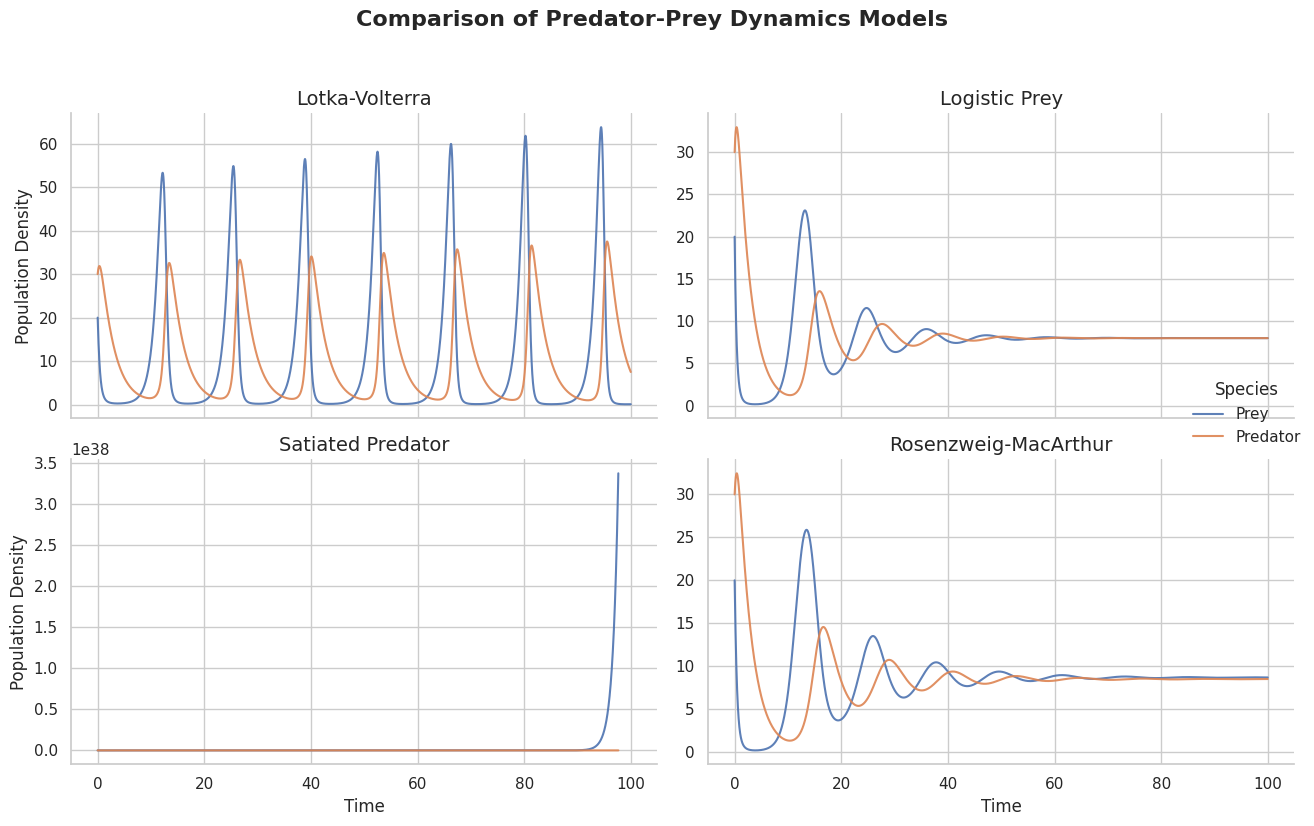

In [125]:

# --- 5. Visualization using Seaborn ---

# Set a nice style
sns.set_theme(style="whitegrid")

# Create a FacetGrid to plot each model in its own subplot
g = sns.FacetGrid(results_df, col="model", col_wrap=2, hue="species", height=4, aspect=1.5, sharey=False)

# Map the lineplot onto the grid
g.map(sns.lineplot, "time", "population", alpha=0.9)

# Add titles, legends, and labels
g.set_titles("{col_name}", size=14)
g.set_axis_labels("Time", "Population Density")
g.add_legend(title="Species")
g.fig.suptitle("Comparison of Predator-Prey Dynamics Models", y=1.03, fontsize=16, weight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Lynx and Hare Population Dynamics

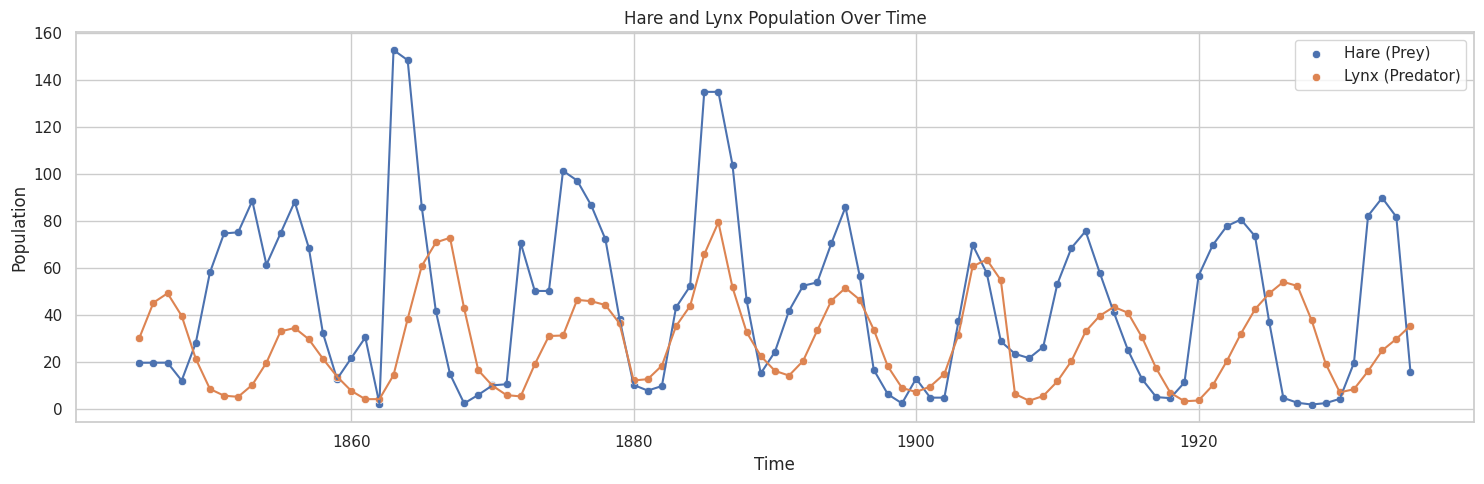

In [69]:
url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, sep=r'\s+', header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

time = torch.tensor(df.index.values)
df.index = df.index - df.index.min()
index = torch.tensor(df.index.values)
hare, lynx = torch.tensor(df['Hare'].values), torch.tensor(df['Lynx'].values)


plt.figure(figsize=(15,5))
sns.scatterplot(x=time, y=hare, label='Hare (Prey)')
sns.lineplot(x=time, y=hare)
sns.scatterplot(x=time, y=lynx, label='Lynx (Predator)')
sns.lineplot(x=time, y=lynx)


plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Hare and Lynx Population Over Time')
plt.tight_layout()
plt.show()

## Create Training Data

In [115]:
class prior_distributions:
    def __init__(self):
        self.N = torch.distributions.Uniform(0, 200)
        self.P = torch.distributions.Uniform(0, 200)
        self.r = torch.distributions.Uniform(0, 1)
        self.a = torch.distributions.Uniform(0, 1)
        self.m = torch.distributions.Uniform(0, 1)
        self.K = torch.distributions.Uniform(0, 100)

    def sample(self, num_samples=1):
        N = self.N.sample((num_samples,))
        P = self.P.sample((num_samples,))
        r = self.r.sample((num_samples,))
        a = self.a.sample((num_samples,))
        m = self.m.sample((num_samples,))
        K = self.K.sample((num_samples,))

        init_state = torch.concat([N, P])
        params = {
            "r": r,
            "a": a,
            "m": m,
            "K": K
        }

        return init_state, params

prior = prior_distributions()

In [116]:
# --- 4. Run Simulations and Collect Data ---

# A list to store all results for plotting
all_results = []

for model_name, model_func in models.items():
    # Run the solver for the current model
    for _ in range(10):
        init_state, params = prior.sample()

        t_max = 30
        dt = 0.01

        time, history = solve_ode(model_func, init_state, params, t_max, dt)

        # Convert results to NumPy for Pandas
        time_np = time.numpy()
        history_np = history.numpy()
        
        # Format data into a "tidy" DataFrame for Seaborn
        df_prey = pd.DataFrame({
            'time': time_np,
            'population': history_np[:, 0],
            'species': 'Prey',
            'model': model_name
        })
        
        df_predator = pd.DataFrame({
            'time': time_np,
            'population': history_np[:, 1],
            'species': 'Predator',
            'model': model_name
        })
        
        all_results.append(df_prey)
        all_results.append(df_predator)

    # Combine all individual DataFrames into a single one
    results_df = pd.concat(all_results)

In [118]:
# only get the full integer timesteps
time = time[time % 1 == 0]
history = history[time % 1 == 0]

IndexError: The shape of the mask [30] at index 0 does not match the shape of the indexed tensor [3000, 2] at index 0

In [119]:
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29.])